# Continuous-Time Dynamic Network Embeddings

This demo shows how to do time respecting random walks on graphs that have a time attribute over its edges. Continuous-Time Dynamic Network Embeddings is implemented in Stellargraph. This demo is to show in simple steps how time respecting walks can be done on a temporal graph and how they can be used to get network embeddings. 

We compare the embeddings learnt from temporal walks with non-temporal walks in this demo. 

## Data set

We use the **Social Spammers in Evolving Multi-Relational Social Network Dataset** to demonstrate the continuous-time dynamic network embeddings method. This dataset was released by Shobeir Fakhraei with permission from if(we) Inc. as supplementary material of the paper: [Collective Spammer Detection in Evolving Multi-Relational Social Networks](http://www.cs.umd.edu/~shobeir/papers/fakhraei_kdd_2015.pdf)

The original anonymized dataset was collected from the Tagged.com social network website.

It contains 5.6 million users and 858 million links between them.

Each user has 4 features and is manually labeled as "spammer" or "not spammer".

Each link represents an action between two users and includes a timestamp and a type.

The network contains 7 anonymized types of links. The original task on the dataset is to identify (i.e., classify) the spammer users based on their relational and non-relational features.

https://linqs-data.soe.ucsc.edu/public/social_spammer/

<a name="refs"></a>
**References**

[1] Continuous-Time Dynamic Network Embeddings. Giang Hoang Nguyen, John Boaz Lee, Ryan A. Rossi, Nesreen K. Ahmed. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. ([link](http://ryanrossi.com/pubs/nguyen-et-al-WWW18-BigNet.pdf))

[2] Collective Spammer Detection in Evolving Multi-Relational Social Networks.Fakhraei, Shobeir and Foulds, James and Shashanka, Madhusudana and Getoor, Lise. Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. KDD 2015. ([link](http://www.cs.umd.edu/~shobeir/papers/fakhraei_kdd_2015.pdf))


### Details of the method:
The overall approach of temporal random walks is  quite simple. Starting from a node randomly pick each the next node forward in time. 
### Choices made in the paper: 
 * Initial temporal edge selection:  Where to start the walk? 
    * Unbiased:
        * Uniformly at random select a starting edge.
    * Biased:
        * Exponential
        * Linear

 * Temporal random walks: How to select the next edge? 
    * Unbiased:
       
       Uniformly at random select the next edge that has a timestamp greater than the current timestamp and starts at the destination node of the current edge.
    * Biased: 
        * Exponential 
        * Linear

* Arbitrary length of walks:
    
    Unlike timeless random walks, there may not be enough options to perform a time-based random walk of a certain fixed length L. A minimum value \omega is set for a minimum viable walk. All walks of length greater than and equal to omega and less than and equal to L are considered as valid walks to extract the (target, context ) pairs.



**Stellargraph strategies:**

* Initial temporal edge selection:  Where to start the walk? 
        * Slightly departing from the paper’s idea, given a set of head nodes, uniformly at random select a starting edge.
        
* Temporal random walks: How to select the next edge? 
* Bidirectional walks: the walker can perform forward or bidirectional *time respecting* random walks continuting from the latest or both outer end nodes of the random walk 
    * Nearest in time. 
    * Break ties uniformly at random.


In [1]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import random
from numpy.random import choice
import math

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
os.getcwd()

'/Users/hab031/Documents/stellargraph/demos/embeddings'

In [3]:
data_path = "../../../datasets/" 

In [4]:
os.listdir(data_path)

['aminer',
 '.DS_Store',
 'asic-abr',
 'usersdata.csv.gz',
 'stellargraph',
 'README.md',
 '.gitignore',
 'Cora',
 'relations.csv.gz',
 '1.txt',
 'summarised-partial-yelp',
 'subset.txt',
 'relations.csv',
 'usersdata.csv',
 '.git',
 'bitcoin-OTC',
 'companies-house',
 'panama-paradise-papers']

In [5]:
df_users = pd.read_csv(data_path + 'usersdata.csv', sep='\t', header=None)
df_users.columns = ['userID', 'gender', 'timePassedValidation','ageGroup', 'label']

In [6]:
df_users.head()

,userID,gender,timePassedValidation,ageGroup,label
0,1,M,0.9000,30,0
1,2,F,1.0000,20,0
2,3,M,0.1375,30,0
3,4,M,0.3875,20,0
4,5,M,0.0125,20,0


In [7]:
df_users['userID'] = df_users['userID'].astype('str')

In [8]:
df_relations = pd.read_csv(data_path + 'relations.csv', sep ='\t', header=None)
df_relations.columns = ['day', 'time_ms', 'source', 'target', 'relations']

In [9]:
df_relations.shape

(858247099, 5)

In [10]:
df_relations_day0 =  df_relations[df_relations['day'] == 0]

In [11]:
df_relations_day0.shape

(85470637, 5)

In [12]:
len(df_relations_day0.time_ms.unique())

52797812

In [13]:
len(df_relations_day0.source.unique())

2158882

In [14]:
len(df_relations_day0.target.unique())

4032095

In [15]:
df_relations_day0.relations.unique()

array([5, 6, 3, 4, 2, 1, 7])

In [16]:
df_relations_day0_rel1 = df_relations_day0[df_relations_day0['relations'] == 1]

In [17]:
df_relations_day0_rel1.shape

(606315, 5)

In [18]:
df_relations_day0_rel1['source'] = df_relations_day0_rel1['source'].astype('str')
df_relations_day0_rel1['target'] = df_relations_day0_rel1['target'].astype('str')

/anaconda3/envs/stellargraph/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/stellargraph/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
# create lit of unique users from source and target
u1 = df_relations_day0_rel1.iloc[:,2]
u2 = df_relations_day0_rel1.iloc[:,3]
users_day_0 = pd.concat([u1, u2], ignore_index=True)
users_day_0 = pd.Series.unique(users_day_0)
print("In the network there are {} users out of total {} users.".format(len(users_day_0), len(df_users)))

In the network there are 417273 users out of total 5607447 users.


In [20]:
spammer_dist = df_users[df_users['userID'].isin(users_day_0)].label.value_counts()
print("The distribution of spammers in our network is\n {}".format(spammer_dist))

The distribution of spammers in our network is
 0    384977
1     32296
Name: label, dtype: int64


In [21]:
GDay0= nx.from_pandas_edgelist(df_relations_day0_rel1, 'source', 'target', edge_attr=['time_ms'], 
                                 create_using=nx.MultiGraph())

In [22]:
print(nx.info(GDay0))

Name: 
Type: MultiGraph
Number of nodes: 417273
Number of edges: 606315
Average degree:   2.9061


In [23]:
node_attr = df_users[df_users['userID'].isin(users_day_0)]
values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows() }
nx.set_node_attributes(GDay0, values, 'label')

## Temporal Uniform random walks

In [24]:
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import TemporalUniformRandomWalk
from stellargraph.data import TemporalBiasedRandomWalk

/anaconda3/envs/stellargraph/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/stellargraph/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/stellargraph/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/stellargraph/lib/python3.6/site-packages/tensorf

In [25]:
nodes = list(GDay0.nodes)
n = 5
length = 80
bidirectional = True

In [26]:
?TemporalUniformRandomWalk

Init signature: TemporalUniformRandomWalk(graph, graph_schema=None, seed=None)
Docstring:      Performs uniform temporal random walks on the given graph
File:           ~/Documents/stellargraph/stellargraph/data/explorer.py
Type:           type
Subclasses:     


In [27]:
?TemporalBiasedRandomWalk

Init signature: TemporalBiasedRandomWalk(graph, graph_schema=None, seed=None)
Docstring:      Performs exponentially biased temporal random walks on the given graph
File:           ~/Documents/stellargraph/stellargraph/data/explorer.py
Type:           type
Subclasses:     


In [28]:
rw = BiasedRandomWalk(StellarGraph(GDay0))

walks = rw.run(
    nodes=nodes, # root nodes
    length=length,  # maximum length of a random walk
    n=n,        # number of random walks per root node 
    p=0.5,       # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0        # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 2086365


In [29]:
trw_uniform = TemporalUniformRandomWalk(StellarGraph(GDay0))

In [31]:
temporal_random_walks = trw_uniform.run(
    nodes=nodes, # root nodes
    length=length,  # maximum length of a random walk
    n=n,
    bidirectional= bidirectional,
    edge_time_label="time_ms"
    
)
print("Number of random walks: {}".format(len(temporal_random_walks)))

Number of random walks: 2086365


In [33]:
trw_biased = TemporalBiasedRandomWalk(StellarGraph(GDay0))

In [35]:
temporal_biased_random_walks = trw_biased.run(
    nodes=nodes, # root nodes
    length=length,  # maximum length of a random walk
    n=n,
    edge_time_label="time_ms"
)
print("Number of random walks: {}".format(len(temporal_biased_random_walks)))

/Users/hab031/Documents/stellargraph/stellargraph/data/explorer.py:1099: RuntimeWarning: overflow encountered in exp
  np.exp(t - current_time) for t in times
/Users/hab031/Documents/stellargraph/stellargraph/data/explorer.py:1106: RuntimeWarning: invalid value encountered in double_scalars
  exp_dist = [t / sum_time_dist for t in time_dist]  # exponential distribution


Number of random walks: 2086365


### Representation Learning using Word2Vec

We use the Word2Vec [[2]](#refs) implementation in the free Python library gensim [[3]](#refs), to learn representations for each node in the graph.

We set the dimensionality of the learned embedding vectors to 128 as in [[1]](#refs).

In [37]:
from gensim.models import Word2Vec

In [38]:
model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [39]:
model_temporal_uniform = Word2Vec(temporal_random_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [40]:
model_temporal_biased = Word2Vec(temporal_biased_random_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

### Visualise Node Embeddings

We retrieve the Word2Vec node embeddings that are 128-dimensional vectors and then we project them down to 2 dimensions using the [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm.

### Biased Random walks

In [68]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ GDay0.node[node_id]['label'] for node_id in node_ids ]

Transform the embeddings to 2d space for visualisation

In [69]:
transform = PCA #TSNE

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

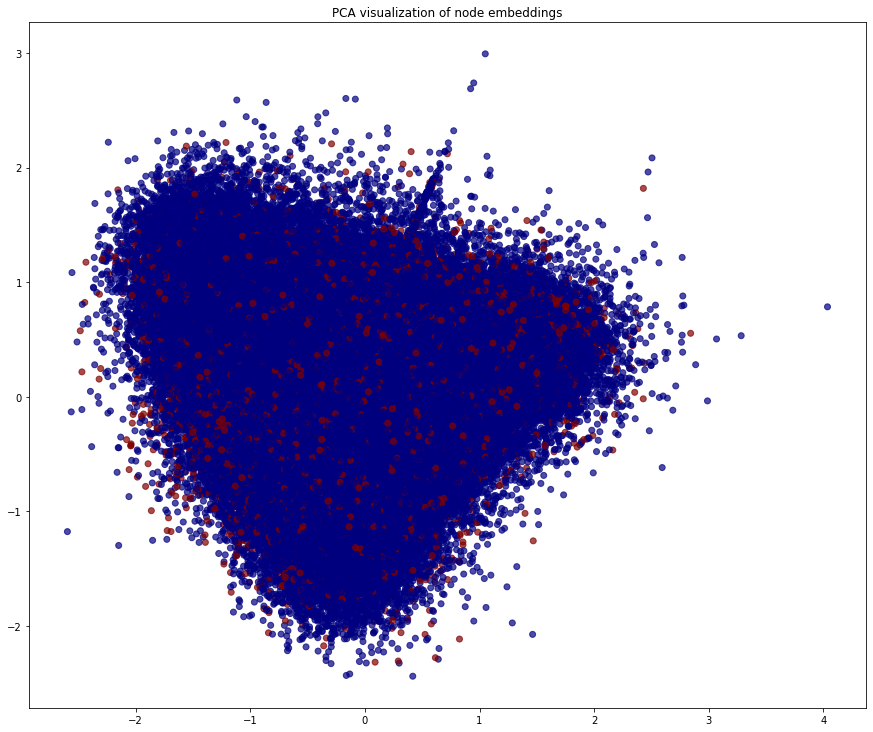

In [70]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = { l: i for i, l in enumerate(np.unique(node_targets)) }
node_colours = [ label_map[target] for target in node_targets ]

plt.figure(figsize=(15,15))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, cmap="jet", alpha=alpha)
plt.title('{} visualization of node embeddings'.format(transform.__name__))
plt.show()

### Temporal Uniform Random walks

In [65]:
# Retrieve node embeddings and corresponding subjects
node_ids = model_temporal_uniform.wv.index2word  # list of node IDs
node_embeddings = model_temporal_uniform.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ GDay0.node[node_id]['label'] for node_id in node_ids ]

Transform the embeddings to 2d space for visualisation

In [66]:
transform = PCA #TSNE

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

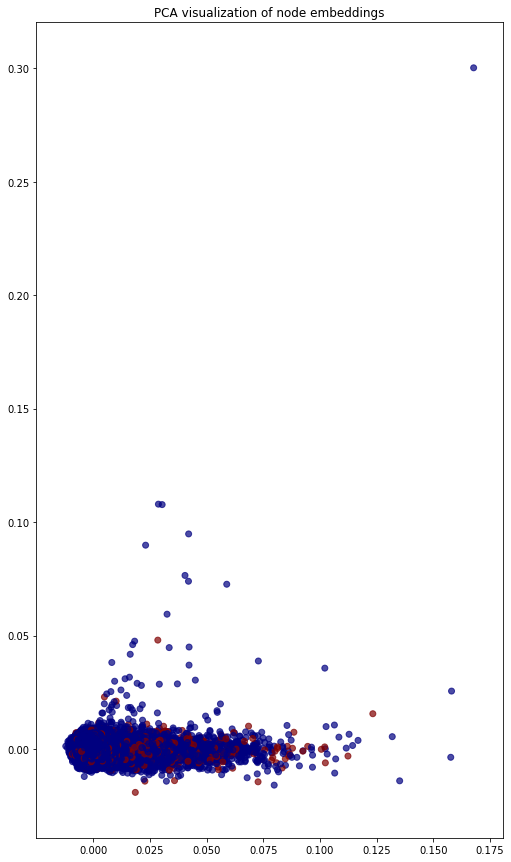

In [67]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = { l: i for i, l in enumerate(np.unique(node_targets)) }
node_colours = [ label_map[target] for target in node_targets ]

plt.figure(figsize=(15,15))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, cmap="jet", alpha=alpha)
plt.title('{} visualization of node embeddings'.format(transform.__name__))
plt.show()

### Temporal Biased Random walks

In [60]:
# Retrieve node embeddings and corresponding subjects
node_ids = model_temporal_biased.wv.index2word  # list of node IDs
node_embeddings = model_temporal_biased.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ GDay0.node[node_id]['label'] for node_id in node_ids ]

Transform the embeddings to 2d space for visualisation

In [61]:
transform = PCA #TSNE

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

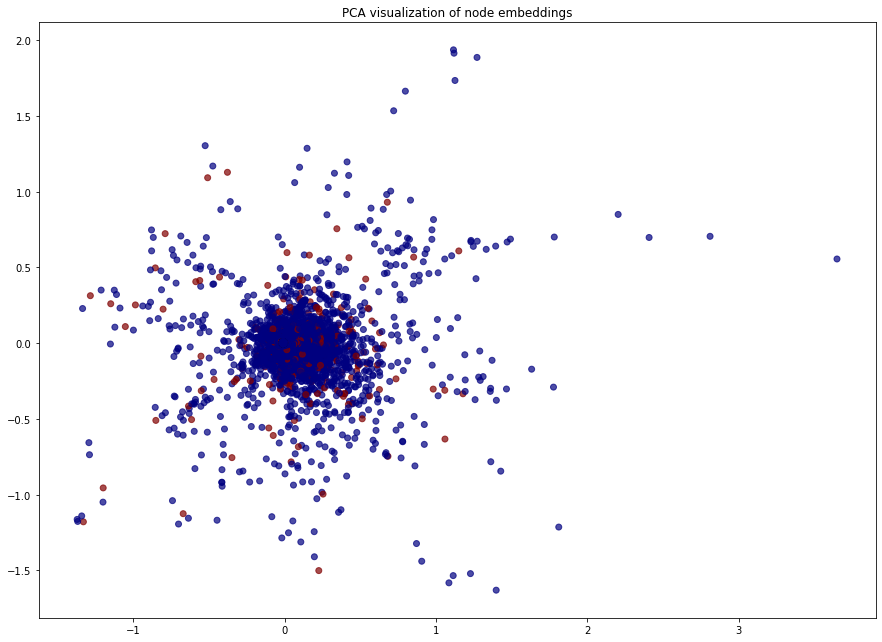

In [64]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = { l: i for i, l in enumerate(np.unique(node_targets)) }
node_colours = [ label_map[target] for target in node_targets ]

plt.figure(figsize=(15,15))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, cmap="jet", alpha=alpha)
plt.title('{} visualization of node embeddings'.format(transform.__name__))
plt.show()

### Downstream task

The node embeddings calculated using Word2Vec can be used as feature vectors in a downstream task such as node attribute inference (e.g., inferring the subject of a paper in Cora), community detection (clustering of nodes based on the similarity of their embedding vectors), and link prediction (e.g., prediction of citation links between papers).

For a more detailed example of using Node2Vec for link prediction see [this example](https://github.com/stellargraph/stellargraph/tree/master/demos/link-prediction/random-walks/cora-lp-demo.ipynb).